In [87]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from saf.filters import n_fold_filter, gaussian_filter, annulus_filter
from saf.ratchet_model import regress_offset_cw
from saf.stm_helpers import regress_annulus
from skimage.feature import peak_local_max
from tqdm import tqdm
from pathlib import Path

In [70]:
def thresholding(image_array, threshold):
    """
    thresholding function to remove impurities
    """
    # Normalize the image array
    image_array = (image_array - image_array.min()) / (image_array.max() - image_array.min())
    # Apply the threshold
    image_array[image_array > threshold] = 0
    # Normalize again after thresholding
    image_array = (image_array - image_array.min()) / (image_array.max() - image_array.min())
    return image_array


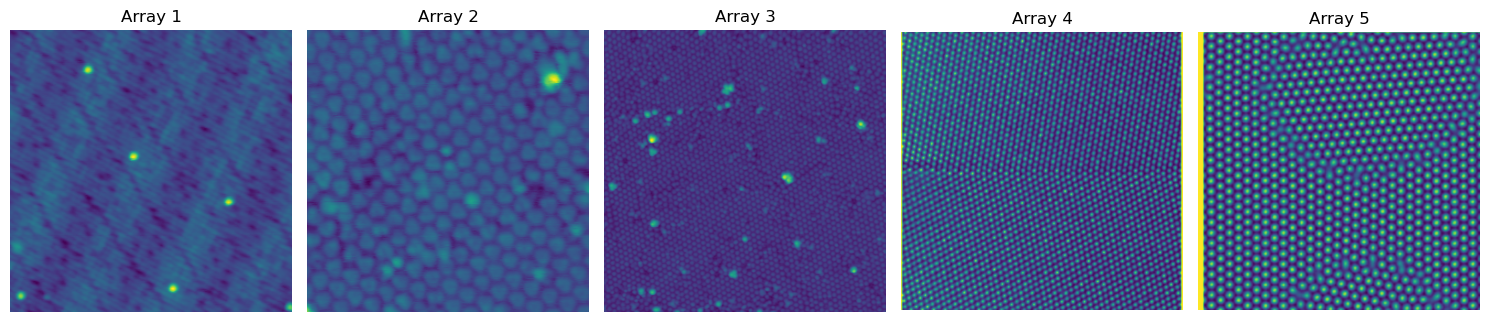

(420, 425)


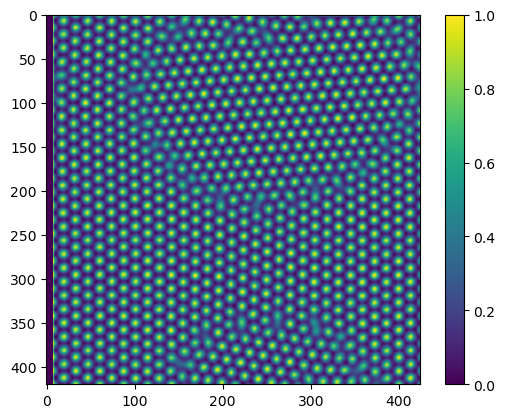

In [81]:
data_dir = '/Users/cadenmyers/billingelab/dev/sym_adapted_filts/data/STM_data/'

# Path to the image
tem_im = data_dir + "6foldTEM.png"

# Load the image and convert to grayscale
image = Image.open(tem_im).convert("L")  # "L" mode for grayscale
image_array = np.array(image)

# separate image_array in two halves at x index of 425
image_array = image_array.astype(np.float32)  # Ensure the array is in float format

# Convert to NumPy array

# Load the data
path1 = data_dir + "20241123_Lu166_0023.txt"
path2 = data_dir + "20241206_Lu166_0041.txt"
path3 = data_dir + "20241206_Lu166_0043.txt"

array1 = np.loadtxt(path1)
array2 = np.loadtxt(path2)
array3 = np.loadtxt(path3)
array4 = image_array[:, :425]  # Keep only the left half
array5 = image_array[:, 425:]  # Keep only the right half

# Plot all arrays
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
axes = axes.flatten()  # Flatten the 2D array to a 1D array for easy indexing

axes[0].imshow(array1, cmap='viridis')
axes[0].set_title("Array 1")
axes[0].axis('off')

axes[1].imshow(array2, cmap='viridis')
axes[1].set_title("Array 2")
axes[1].axis('off')

axes[2].imshow(array3, cmap='viridis')
axes[2].set_title("Array 3")
axes[2].axis('off')

axes[3].imshow(array4, cmap='viridis')
axes[3].set_title("Array 4")
axes[3].axis('off')

axes[4].imshow(array5, cmap='viridis')
axes[4].set_title("Array 5")
axes[4].axis('off')

plt.tight_layout()
plt.show()

image_array = array5

image_array = thresholding(image_array,.9)
print(image_array.shape)
plt.imshow(image_array)
plt.colorbar()





## Find coordinates of clusters
Using `peak_local_max` from `skimage.feature`

In [82]:

coordinates = peak_local_max(image_array, min_distance=5)
print(len(coordinates))


807


## Plot gaussians at each coord.
Use this to view how the peak location worked

(420, 425)


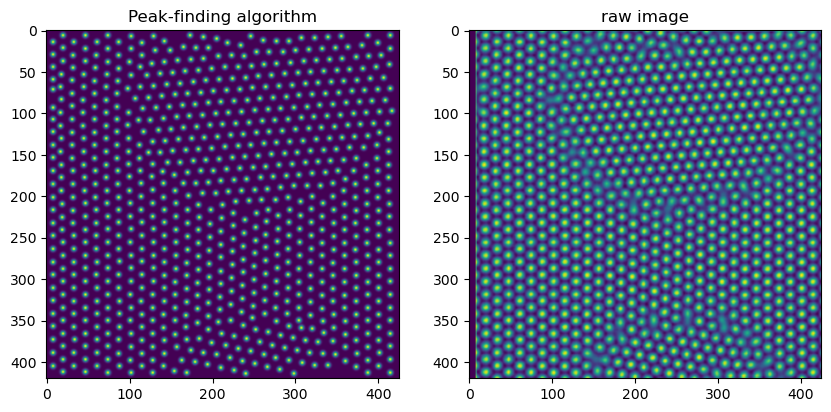

In [83]:
# Compile all gaussians into one array
filt = np.zeros_like(image_array)

for i in range(len(coordinates)):
    y, x = coordinates[i]
    filt += gaussian_filter(2, imshape=image_array.shape, cx=x, cy=y)

# filt = gaussian_filter(2, imshape=array3.shape, cx=coordinates[0][0], cy=coordinates[0][1])
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
print(image_array.shape)
ax[0].imshow(filt)
ax[0].set_title("Peak-finding algorithm")
ax[1].imshow(image_array)
ax[1].set_title("raw image")
plt.show()


## Mask with annulus

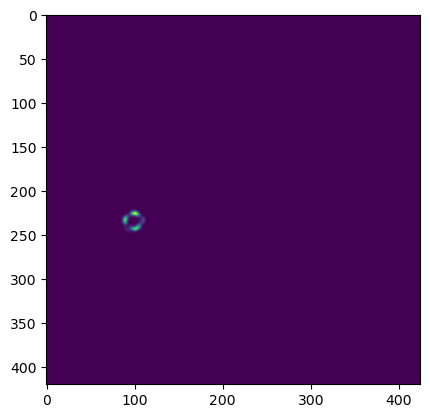

In [85]:
# Now we can use the annulus filter to regress the annulus

# Select a point from the coordinates to regress the annulus
cx, cy = coordinates[50]
r, filtered_im = regress_annulus(r_min=3, r_max=20, array=image_array, cx=cx, cy=cy, sd=2, r_step=1)
nfilter = n_fold_filter(k=8, offset=0, n_folds=6, imshape=image_array.shape, cx=cx, cy=cy)

# Verify that the regression is working correctly
plt.imshow(filtered_im)

# Calculate the offset value, not displayed below but just run to see if it works
offset1, _ = regress_offset_cw(image_array, n_folds=6, k=8, tolerance_forward=30, tolerance_reverse=0, cx=cx, cy=cy, offset_step=1)

## Put it all together
Now, we can run everything together.
1) Use `peak_local_max` to find the peaks in the original STM image. Gives you `coordinates` where each peak is located.
2) At each peak location, regress with an annulus. This will find the first outer ring of atoms from the above points. The filtered image that it returns masks everything out except the first "ring" of atoms. If no ring is detected (due to impurities, grain boundaries, etc) it will set the filtered ring distance to `r_min`. This step generates a list of images where `len(coordinates)==len(filtered_ims_cx_cy)`
3) Lastly, find the orientation of each angle using our ratchet model. This returns a list of offsets values where `len(coordinates)==len(offsets)`
4) This can then be plotted however you like, recommendation is a quiver plot

In [88]:
# 1. find center points
coordinates = peak_local_max(image_array, min_distance=3)
print("number of coordinates found:", len(coordinates))

# 2. find radius of each point using annulus filter regression
filtered_ims_cx_cy = []
radii = []
max_radius_calculated = 0
r_min = 3
r_max = 20
for i, coord in enumerate(coordinates):
    cy, cx = coord
    r, filtered_im = regress_annulus(r_min=r_min, r_max=r_max, array=image_array, cx=cx, cy=cy, sd=2, r_step=1)
    filtered_ims_cx_cy.append((filtered_im, cx, cy))
    radii.append(r)
    if r > max_radius_calculated:
        max_radius_calculated = r
        print('max radius calculated=', max_radius_calculated, f' at {i}')

# 3. regress offset using ratchet model
print("Starting offset regression...")
n_folds = 6
k = 8
tol_forward = 30
tol_reverse = 0
offset_step = 1
offsets = []
offsets = []

for tup in tqdm(filtered_ims_cx_cy, desc="Computing Offsets"):
    filtered_im, cx, cy = tup
    offset, _ = regress_offset_cw(
        dps=filtered_im,
        n_folds=n_folds,
        k=k,
        tolerance_forward=tol_forward,
        tolerance_reverse=tol_reverse,
        cx=cx,
        cy=cy,
        offset_step=offset_step
    )
    offsets.append(offset[0])

# 4. create heatmap of orientation angles

number of coordinates found: 813
max radius calculated= 15  at 0
max radius calculated= 16  at 303
Starting offset regression...


Computing Offsets: 100%|██████████| 813/813 [23:06<00:00,  1.70s/it]


In [90]:
# stm_data = np.load('/Users/cadenmyers/billingelab/dev/sym_adapted_filts/data/STM_data/STMorientation_field.npz')
# offset = stm_data['offsets']
# coordinates = stm_data['coordinates']
print(offsets.shape)

# offsets returns a lists of lists, there is probably a but somewhere. This fixes that.
# offset_values = [val[0] for val in offsets]

AttributeError: 'list' object has no attribute 'shape'

## Plotting quiver plot

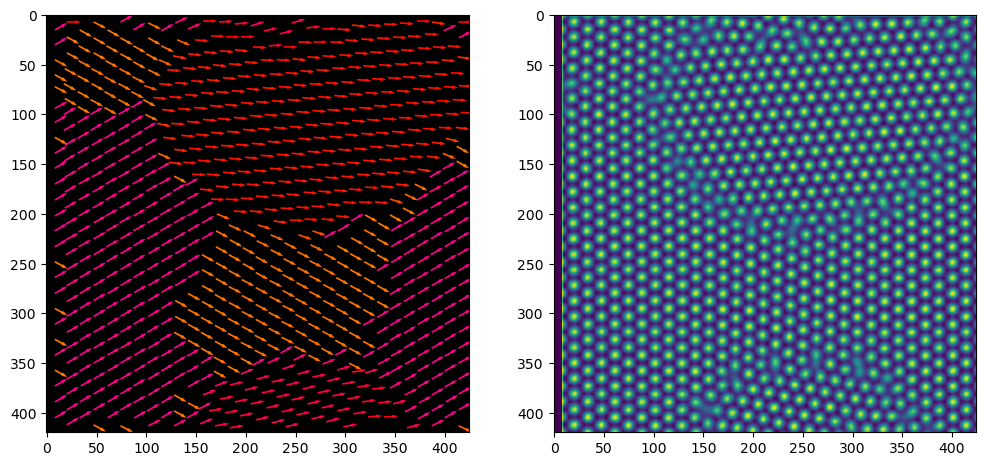

In [95]:
offsets_rad = np.deg2rad(offsets)  # convert degrees to radians
shape = image_array.shape
# Extract x and y positions
x = coordinates[:, 0]
y = coordinates[:, 1]

# Compute arrow components
u = np.cos(offsets_rad)  # x-direction
v = np.sin(offsets_rad)  # y-direction

# Normalize angle to 0–1 range for colormap
colors = (np.array(offsets) % 360) / 360  # stays in [0, 1]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # wider figure to fit 2 plots

# Plot on the first axes
ax[0].imshow(np.zeros(shape), cmap='gray')
quiv = ax[0].quiver(
    y, x, u, v, colors, cmap='hsv',      # flip x and y for correct orientation
    angles='xy', scale_units='xy', scale=0.07, width=0.004,
    headwidth=2, headaxislength=4, headlength=3
)

# ax[0].set_xlim(0, 512)
# ax[0].set_ylim(0, 512)
# ax[0].invert_yaxis()
# ax[0].set_title("Orientation Field with Direction-Colored Arrows")

ax[1].imshow(image_array)

# plt.savefig('/Users/cadenmyers/billingelab/dev/sym_adapted_filts/data/STM_data/orientation_field.png', dpi=300, bbox_inches='tight')